# RAG using LlamaIndex

Implement a question answering assistant using LlamaIndex and OpenAI GPT models. This assistant will answer questions related to a specific set of documents and provide the location of its sources.

## Part 1 - Overall RAG Application Specifications

***Problem Statement*** - In this project we are given a set of insurance policy documents and the goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from various policy documents. Policy documents are 7 pdfs with pages ranging from 15 to 44. It is very hard for any individual to go over all those documents and be able to remember the details to not just pick up the right section from the right document but also be able to compare information across the different documents. The generative search system provides a conversational interface to get the right information accurately and quickly. LlamaIndex has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

***Solution Strategy*** - Build a POC which should solve the following requirements:

- Users would get responses from the insurance polices.
- If they want to refer to the original page from which the bot is responding, the bot should provide a citation as well.

Goal - Solving the above two requirements well in the POC would ensure that the accuracy of the overall model is good and therefore further improvisations and customizations make sense.

***Data Used*** -  Policy documents are 7 pdfs with pages ranging from 15 to 44. All the files are in a specified folder. 

***Why LlamaIndex ?*** - LlamaIndex has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

Feature Comparision:		

LangChain
Primary Focus	 - Workflow orchestration with LLMs	
Strengths	- Agents, chains, memory integration	
Best Use Cases	- Chatbots, tool use, multi-step tasks	Querying external knowledge sources

LlamaIndex
Primary Focus	  - Data retrieval and indexing
Strengths	- Custom indexing, efficient retrieval
Best Use Cases	- Querying external knowledge sources

Our use case is more reliant on external data sources [Policy PDFs provided]. We will need custom indexing and efficient retrieval from those external sources. So LlamaIndex is more suitable for the purpose. LangChain is better suited for complex workflows and agents. This is not a problem we need to solve in the project as the workflow is fairly basic.


## Part 2 - Solution POC

In this section, we go ahead and actually build a POC of the solution that we proposed in the previous step.

### Step 1: Import the necessary libraries

While installing LlamaIndex, you can specify the version to install. We are installing version `v0.10.34`, which was the latest release version at the time of writing this notebook.

In [1]:
# %pip install llama-index==0.10.34
!pip install -U -qq openai llama-index llama-index-core llama-index-readers-file llama-index-llms-openai llama-index-embeddings-openai

In [1]:
# NOTE: This is ONLY necessary in jupyter notebook.
# Details: Jupyter runs an event-loop behind the scenes.
#          This results in nested event-loops when we start an event-loop to make async queries.
#          This is normally not allowed, we use nest_asyncio to allow it for convenience.
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Llama index already has its bundle which comes with OpenAI package included and will work even if you do not import openai separately.
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import os
import openai

### Step 2 : Set the Open AI API key

In [3]:
# Set the API key
filepath = "D:\\ML\\code\\"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

Let's check if the OpenAI API is working correctly

In [4]:
messages = [
    ChatMessage(role="system", content="You are an AI assistant to the user."),
    ChatMessage(role="user", content="What is the revenue of PayPal in 2021?")
]
resp = OpenAI().chat(messages)
print(resp)

assistant: PayPal's revenue in 2021 was approximately $25.3 billion.


### Step 3 - Data Loading (Ingestion)

##### Using SimpleDirectoryReader
Here are some attributes that can be passed to the `SimpleDirectoryReader`:

* `input_dir`: The directory from which you have to load files.
* `recursive`: If set to *True*, it will read files from subdirectories too.
* `input_files`: A list of specific file paths to load.
* `exclude`: A list of file paths to exclude.

Refer to [this documentation](https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/) for more info on SimpleDirectoryReader


In [5]:
from llama_index.core import SimpleDirectoryReader
input_dir =  "D:\\ML\\data\\policy\\"
# Let us take input from a directory
reader = SimpleDirectoryReader(input_dir)

In [6]:
# Use the load_data() method to read the files from the directory
documents = reader.load_data()
# number of files
print(f"Loaded {len(documents)} docs")

Loaded 217 docs


In [7]:
type(documents)

list

Note: <br>

217 documents is a lot more than the actual number of files you can see if you open this directory. This is because the reader is considering each page as one document. This is better because more information about less text can be stored in the metadata. See an example where we read the first document from the list.

In [8]:
documents[0]

Document(id_='0488fca3-2400-4228-853c-4232e7aea861', embedding=None, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_type': 'application/pdf', 'file_size': 1303156, 'creation_date': '2023-09-29', 'last_modified_date': '2024-10-23'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \n \n            Part A \n<<Date>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>> \n \nDear <<Policyholder’s Name>>,  \n \nSub: Your Policy no. <<  >> \nWe are glad to inform you that your proposal has been accepted and the HDFC Life Easy Health (“Policy”) \nbeing this docume

### Core Components Of LlamaIndex

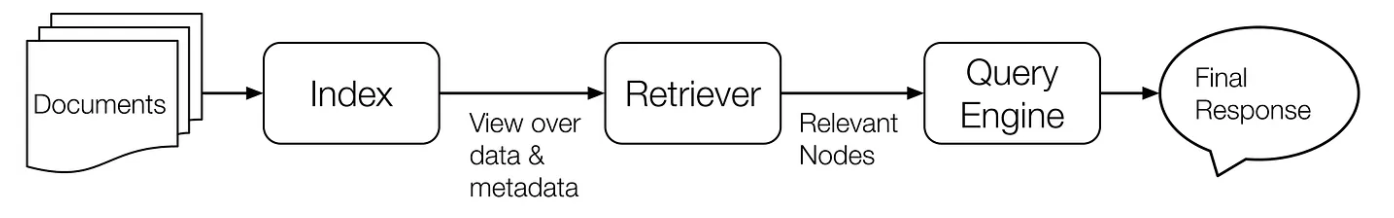

You can understand the core components of Llamaindex with this analogy:
1. Documents: These are the "books" in your library.
2. Index: It's the "library" of your data - Stores your data.
3. Retriever: It's the "librarian" that finds relevant data - Finds data.
4. Response Synthesizer: It's the "storyteller" that creates a response - Makes responses.
5. QueryEngine: It's the "director" that makes everything work together - Coordinates everything.

In [9]:
# Sample usage of Documents and Nodes

# Documents

from llama_index.core import Document, VectorStoreIndex

# text_list = [text1, text2, ...]
# documents = [Document(text=t) for t in text_list]

text = 'text'
docs = [Document(text=text)]

# build index
index = VectorStoreIndex.from_documents(docs)
print(index)

# Nodes

from llama_index.core.node_parser import SentenceSplitter

# load documents
# documents = documents

# parse nodes
parser = SentenceSplitter()
nodes = parser.get_nodes_from_documents(docs)

# build index
index = VectorStoreIndex(nodes)

print(nodes[0])
print(index)

Node ID: f8a35a08-5f19-4faf-861f-d93064b33084
Text: text


**Node Parser**: [Node parsers](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules/#node-parser-modules) chunk a document into nodes. There are several file-based node parsers, that will create nodes based on the type of content that is being parsed (JSON, Markdown, etc.)

However, for better manageability and efficiency in parsing, you can first split the text. This is done using splitters.<br>
**Splitters** are responsible for breaking down the text into smaller, manageable pieces, often called chunks or nodes. These chunks can be based on various criteria such as sentence boundaries, semantic similarity, or other custom rules.

#### Index
An `Index` is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for RAG use-cases.

At a high-level, `Indexes` are built from Documents. They are used to build Query Engines and Chat Engines which enables question & answer and chat over your data.

Under the hood, Indexes store data in Node objects, and expose a Retriever interface that supports additional configuration and automation.

The most common index by far is the VectorStoreIndex.

##### Using VectorStoreIndex#
Vector Stores are a key component of RAG and so you will end up using them in nearly every application you make using LlamaIndex, either directly or indirectly.

Vector stores accept a list of Node objects and build an index from it.
<br>

**Loading data into the index**

The simplest way to use a Vector Store is to load a set of documents and build an index from them using from_documents:

In [10]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
# Load documents and build index
index = VectorStoreIndex.from_documents(documents)

Tip:

If you are using `from_documents` on the command line, it can be convenient to pass `show_progress=True` to display a progress bar during index construction.

When you use `from_documents`, your Documents are split into chunks and parsed into Node objects, lightweight abstractions over text strings that keep track of metadata and relationships.

#### Retrievers and ResponseSynthesizers
**Retrievers** are responsible for fetching the most relevant context given a user query (or chat message).

It can be built on top of indexes, but can also be defined independently. It is used as a key building block in query engines (and Chat Engines) for retrieving relevant context.
```
retriever = index.as_retriever()
nodes = retriever.retrieve("What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan, with the  Lump Sum Option ?")
```

**ResponseSynthesizers** generate a response from an LLM, using a user query and a given set of text chunks. The output of a response synthesizer is a Response object.

The method for doing this can take many forms, from as simple as iterating over text chunks, to as complex as building a tree.

#### Query Engines
Query engine is a generic interface that allows you to ask question over your data.

A query engine takes in a natural language query, and returns a rich response. It is most often (but not always) built on one or many indexes via retrievers. You can compose multiple query engines to achieve more advanced capability.


``` Python
query_engine = index.as_query_engine()
response = query_engine.query("What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan, with the  Lump Sum Option ?")
```

To stream response: <br>
LlamaIndex supports streaming the response as it's being generated. This allows you to start printing or processing the beginning of the response before the full response is finished, so you can see the words as they are being generated.

In [12]:
# Streaming
query_engine = index.as_query_engine(streaming=True)
streaming_response = query_engine.query("What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan, with the  Lump Sum Option ?")
streaming_response.print_response_stream()

The Maturity Benefit for HDFC Life Sampoorna Jeevan Plan with the Lump Sum Option includes the Guaranteed Maturity Benefit, which is 100% of the Basic Sum Assured. This amount will be payable on the Policy Maturity Date.

### Step 4 - Building the query engine
A Query Engine wraps a Retriever and a ResponseSynthesizer into a pipeline. It uses the query string to fetch nodes and then sends them to the Large Language Model (LLM) to generate a response.

In [13]:
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core import VectorStoreIndex
from IPython.display import display, HTML

# create parser and parse document into nodes
parser = SimpleNodeParser.from_defaults()
nodes = parser.get_nodes_from_documents(documents)

# # build index
index = VectorStoreIndex(nodes)

# Construct Query Engine
query_engine = index.as_query_engine()

In [14]:
type(index)

llama_index.core.indices.vector_store.base.VectorStoreIndex

You can also store this VectorStoreIndex. You can read more here - https://docs.llamaindex.ai/en/stable/understanding/storing/storing.html

In [15]:
response = query_engine.query("What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan, with the  Lump Sum Option ?")

In [16]:
# Output from a query engine is a response object
type(response)

llama_index.core.base.response.schema.Response

In [17]:
## What are the options available with the response object
dir(response)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_formatted_sources',
 'metadata',
 'response',
 'source_nodes']

In [18]:
# Fetching the response value which contains the actual response inside the response object
response.response

'The Maturity Benefit of HDFC Life Sampoorna Jeevan Plan with the Lump Sum Option includes a Guaranteed Maturity Benefit which is 100% of the Basic Sum Assured.'

In [19]:
# You can also see the metadeta of the response
response.metadata

{'070567de-93db-44ad-b7fb-4917e28f5bf1': {'page_label': '7',
  'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf',
  'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf',
  'file_type': 'application/pdf',
  'file_size': 1990500,
  'creation_date': '2023-09-29',
  'last_modified_date': '2024-10-23'},
 '734e0d30-410a-496a-bba9-9cff1e92c37f': {'page_label': '18',
  'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf',
  'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf',
  'file_type': 'application/pdf',
  'file_size': 1990500,
  'creation_date': '2023-09-29',
  'last_modified_date': '2024-10-23'}}

In [20]:
# These are the nodes used as source
response.source_nodes

[NodeWithScore(node=TextNode(id_='070567de-93db-44ad-b7fb-4917e28f5bf1', embedding=None, metadata={'page_label': '7', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_type': 'application/pdf', 'file_size': 1990500, 'creation_date': '2023-09-29', 'last_modified_date': '2024-10-23'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='194d3681-191e-44e1-8217-42f78e14a102', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '7', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Sampoorna-Jeevan-101

In [21]:
#Extract the file name
response.source_nodes[0].node.metadata['file_name']

'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf'

In [22]:
# We can even extract the file name and page number from where the response was taken
response.source_nodes[0].node.metadata['file_name'] + " page no " + response.source_nodes[0].node.metadata['page_label']

'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf page no 7'

In [23]:
#Extract the score
response.source_nodes[0].score

0.8755695671032216

In [24]:
# Response node text
response.source_nodes[0].node.text

'Option A : Lump Sum Option \n100% of Basic Sum Assured  \n+ \nApplicable Bonus, if declared \n+ \nApplicable Terminal Bonus, if declared \nOption B : Income Option Applicable Bonus, if declared \n+ \nApplicable Terminal Bonus, if declared \nOption C : Lump Sum with  \nIncome Option \nApplicable Bonus, if declared \n+ \nApplicable Terminal Bonus, if declared \n \n \nOption D : Income with Lump sum \nOption \n100% of Basic Sum Assured  \n+ \nApplicable Bonus, if declared,  \n+ \nApplicable Terminal Bonus, if declared \n \n \nC.3.  Survival Benefit/s: Subject to the terms and conditions of this Policy and  Policy remaining In Force and effect,  the \nSurvival Benefits shall be payable by the Company to the Policyholder subject tosurvival of the Life Assured during the \nPolicy Term. Survival Benefit payable shall be based on the Guaranteed Benefit Option and Bon us Option chosen by \nPolicyholder on Date of Inception of the Policy. In case of death of the Life Assured after the beginning

### Step 5 - Creating a response Pipeline

User receives the response and the document that they can refer to

In [25]:
## Query response function
def query_response(user_input):
  response = query_engine.query(user_input)
  file_name = response.source_nodes[0].node.metadata['file_name'] + " page nos " + response.source_nodes[0].node.metadata['page_label'] + "," + response.source_nodes[1].node.metadata['page_label']
  final_response = response.response + '\n Check further at ' + file_name
  return final_response

In [28]:
def initialize_conv():
  print('Feel free to ask Questions regarding insurance policies. Press exit once you are done')
  while True:
    user_input = input()
    # Type 'exit' to exit conversation
    if user_input.lower() == 'exit':
      print('Exiting the program... bye')
      break
    else:
      response = query_response(user_input)
      display(HTML(f'<p style="font-size:20px">{response}</p>'))

In [29]:
initialize_conv()

Feel free to ask Questions regarding insurance policies. Press exit once you are done


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

### Step 6 - Build a Testing Pipeline

Here we feed a series of questions to the Q/A bot and store the responses along with the feedback on whether it's accurate or not from the user

In [34]:
questions = ['What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan?' ,'With the Lump sum option?',
             'What other policy has better Maturity benefit?']

In [35]:
def testing_pipeline(questions):
  test_feedback  = []
  for i in questions:
    print(i)
    print(query_response(i))
    print('\n Please provide your feedback on the response provided by the bot')
    user_input = input()
    page = query_response(i).split()[-1]
    test_feedback.append((i,query_response(i),page,user_input))

  feedback_df = pd.DataFrame(test_feedback, columns =['Question', 'Response', 'Page','Good or Bad'])
  return feedback_df

In [36]:
import pandas as pd

In [37]:
testing_pipeline(questions)

What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan?
The Maturity Benefit of HDFC Life Sampoorna Jeevan Plan requires the policyholder to provide the original Policy Document, a Discharge Form, a self-attested ID Proof, and bank account details with IFSC code for payment via NEFT. Additionally, for the payment of Survival Benefit, the policyholder needs to furnish the self-attested ID Proof and bank account details as well.
 Check further at HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf page nos 18,2

 Please provide your feedback on the response provided by the bot
With the Lump sum option?
The Lump Sum option provides a guaranteed maturity benefit which is 100% of the Basic Sum Assured payable on the Policy Maturity Date.
 Check further at HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf page nos 7,8

 Please provide your feedback on the response provided by the bot
What other policy has better Maturity benefit?
HDFC

,Question,Response,Page,Good or Bad
0,What information do you have about the Maturit...,The Maturity Benefit of HDFC Life Sampoorna Je...,"18,2",
1,With the Lump sum option?,Guaranteed Maturity Benefit which is 100% of B...,"7,8",
2,What other policy has better Maturity benefit?,HDFC Life Sanchay Plus has a better Maturity b...,"8,37",


## Part 3 - Next Steps


### 3.1 - Building a custom prompt template

We saw that in one of the questions the model was not able to answer properly, or rather give a very detailed answer. Let's see how we can use a custom prompt template to mitigate the issue

**This is similar to the generation layer that we did in HelpMate AI**

In [38]:
response = query_engine.query("What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan?")

In [39]:
response.response

'The Maturity Benefit of HDFC Life Sampoorna Jeevan Plan requires the policyholder to provide the original Policy Document, a Discharge Form, a self-attested ID Proof, and bank account details with IFSC code for payment via NEFT. Additionally, for the payment of Survival Benefit, the same requirements for ID proof and bank account details need to be furnished.'

In [40]:
response.source_nodes[0]

NodeWithScore(node=TextNode(id_='734e0d30-410a-496a-bba9-9cff1e92c37f', embedding=None, metadata={'page_label': '18', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_type': 'application/pdf', 'file_size': 1990500, 'creation_date': '2023-09-29', 'last_modified_date': '2024-10-23'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a3fa7c54-6f1b-4021-a29c-b88c85f569b0', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '18', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_path': 'D:\\ML\\data\\policy\\HDFC-Life-Sampoorna-Jeevan-10

In [41]:
response.source_nodes[1].node.text

'A.1. Policy Preamble \n \nHDFC Life Sampoorna Jeevan  Plan is a non -linked participating individual life insurance savings Policy. A participating \nPolicyentitles the Policyholder to participate in the surplus (profits) of the Company. The Terms and Conditions and the Policy \nSchedule are issued based on the proposal form submitted by the Life Assured /Policyholder. \n \nA.2. Policy Schedule   \n  \nName of the Policy:  HDFC Life Sampoorna Jeevan \nUIN  of the Product 101N158V04 \nPolicy Number  \nDate of the Proposal  \nPolicy Commencement Date  \nRisk Commencement Date  \nAuto Vesting if Life Assured is Minor  \nBasic Sum Assured  \nSum Assured on Death  \nMaturity Age Variant <<Sampoorna Jeevan75/Sampoorna Jeevan100>> \nGuaranteed Benefit Option <<Lumpsum/Income/Lumpsum with Income/Income with Lumpsum>> \nGuaranteed Income Benefit (GIB) INR xxxx \nGuaranteed Income Benefit Date First GIB Date  \nLast GIB Date  \nBonus Option <<SRB/SRIB/Cash/SRB+Cash/SRIB+Cash>> \nPaid-Up Additio

In [42]:
retrieved = response.source_nodes[0].node.text + response.source_nodes[1].node.text

In [45]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user. Provide specific responses in bullet points"},
    {"role":"user", "content":f"""What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan? Check in '{retrieved}' """},
          ]

In [46]:
response2 = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response2.choices[0].message.content

"- **Policy Features for HDFC Life Sampoorna Jeevan Plan:**\n    - Non-linked, Participating Individual Life Insurance Savings Product\n    - Names of entities (HDFC Life Insurance Company Limited and HDFC Life Sampoorna Jeevan Plan) are for identification purposes only\n    - Policy governed by Indian laws with jurisdiction in India\n\n- **Death Benefit for Minor Life Assured:**\n    - Age threshold for commencement of risk based on Life Assured's age\n    - Provisions for death benefits if Life Assured dies within first two policy years\n\n- **Suicide Exclusion Clause:**\n    - Policy outlines conditions and benefits in case of death due to suicide within first 12 months of policy commencement or revival\n\n- **Grace Period and Non-forfeiture Options:**\n    - Specifies the grace period for premium payments and consequences if premiums are not paid within the stipulated period\n\n- **Requirements for Maturity and Death Claims:**\n    - Detailed list of documents and information neede

### 3.2 - Recommendations on how to further improve this
- Based on the testing pipeline's feedback develop a strategy on how to improve the POC further
  - This can be through building a better/cleaner dataset, or utilizing better data pre-processing techniques
- If the accuracy is good enough, think of implementing some more use cases and user stories. Maybe a set of users want to do XYZ, and that requirement needs to be implemented in the solution. Think of a proper tool that can enable you to do that.
- Few suggestions based on the common tools that we have in the pipeline
https://docs.llamaindex.ai/en/stable/optimizing/basic_strategies/basic_strategies.html

***Using Customized Nodes and LLMs***

This can be used if your responses are not accurate or is not being summarized very well



In [47]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

##Initialize the OpenAI model
Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=256)

##Initialize the embedding model
Settings.embed_model = OpenAIEmbedding()

## Initialize the node_parser with the custom node settings
Settings.node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)

## Initialize the num_output and the context window
Settings.num_output = 512
Settings.context_window = 3900

# Create a VectorStoreIndex from a list of documents using the service context
index = VectorStoreIndex.from_documents(documents)

# Initialize a query engine for the index with a specified similarity top-k value
query_engine = index.as_query_engine(similarity_top_k=3)

In [48]:
#Query the engine with a specific question
response = query_engine.query("What information do you have about the Maturity benifit of HDFC Life Sampoorna Jeevan Plan?")

In [49]:
response.response

'The Maturity Benefit of HDFC Life Sampoorna Jeevan Plan is paid to the Policyholder on the Policy Maturity Date, provided the Policy remains in force and the Life Assured survives till the maturity date. The Maturity Benefit amount is based on the Guaranteed Benefit Option chosen by the Policyholder at the inception of the policy, as specified in the Policy Schedule.'